<a href="https://colab.research.google.com/github/777tharun7/Credit-Score-Predictor/blob/main/Benefiaciary_Credit_Scoring_2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping


In [ ]:
#Load dataset
from google.colab import files
uploaded = files.upload()

filename = list(uploaded.keys())[0]
df = pd.read_csv(filename)
print("Dataset Loaded:", filename)
df.head()


IndexError: list index out of range

In [ ]:
# Show all columns
print("Columns in dataset:")
print(df.columns)
print("\nDataset shape:", df.shape)

# Drop ID/name/timestamp columns if present
drop_cols = ['user_id','name','timestamp','verification_date','last_transaction_date']
df = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')

df.head()


Columns in dataset:
Index(['age', 'gender', 'region', 'education_level', 'occupation',
       'annual_income', 'joint_income', 'business_income', 'property_value',
       'loan_amount', 'repayment_score', 'fraud_flag', 'id_verified',
       'document_validity', 'beneficiary_count', 'credit_score',
       'loan_status'],
      dtype='object')

Dataset shape: (20000, 17)


,age,gender,region,education_level,occupation,annual_income,joint_income,business_income,property_value,loan_amount,repayment_score,fraud_flag,id_verified,document_validity,beneficiary_count,credit_score,loan_status
0,24,Female,Mumbai,Diploma,Teacher,3455447,3095322.0,0,31160734,20000000,665,0,Yes,Valid,6,693,Rejected
1,55,Female,Hyderabad,High School,Farmer,664482,2034183.0,906967,8524582,2396276,714,0,Yes,Expired,3,715,Approved
2,49,Male,Ahmedabad,High School,Engineer,1817251,1666092.0,0,7643254,4595100,657,0,Yes,Pending,3,631,Approved
3,40,Male,Chennai,High School,Self Employed,1783071,NaN,196432,16058493,8811611,525,0,Yes,Pending,2,537,Rejected
4,40,Male,Delhi,PhD,Teacher,1734770,NaN,0,10155805,7323761,609,0,Yes,Valid,3,635,Rejected


In [ ]:
# Prepare data (re-assign to be explicit)
selected_features = [
    'annual_income','joint_income','property_value','business_income',
    'loan_amount','repayment_score','beneficiary_count','age'
]
target = 'credit_score'

# use df_model from before; if not present, rebuild:
try:
    df_model
except NameError:
    df_model = df[selected_features + [target]].copy()

# ensure no NaNs
df_model = df_model.fillna(df_model.median())

X = df_model[selected_features].values
y = df_model[target].values

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Shapes — X_train, X_test, y_train, y_test:", X_train.shape, X_test.shape, y_train.shape, y_test.shape)


Shapes — X_train, X_test, y_train, y_test: (16000, 8) (4000, 8) (16000,) (4000,)


In [ ]:
# Missing value handling
df_model = df_model.fillna(df_model.median())   # fill numeric NA with median
print("Any NaN left?", df_model.isnull().sum().sum())


Any NaN left? 0


In [ ]:
# Scaling for ANN (2D input)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Save scaler to disk if you want later (optional)
import joblib
joblib.dump(scaler, "credit_scaler.save")
print("Scaler saved as credit_scaler.save")
print("Scaled shapes:", X_train_scaled.shape, X_test_scaled.shape)


Scaler saved as credit_scaler.save
Scaled shapes: (16000, 8) (4000, 8)


In [ ]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape


((16000, 8), (4000, 8))

In [ ]:
# FIXED CREDIT ANN MODEL

ann_credit = models.Sequential([
    layers.Input(shape=(X_train_scaled.shape[1],)),

    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

ann_credit.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='mse',
    metrics=['mae']
)

ann_credit.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                 │ (None, 128)            │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,289 (48.00 KB)

 Trainable params: 11,905 (46.50 KB)

 Non-trainable params: 384 (1.50 KB)

In [ ]:
# Train ANN
from tensorflow.keras.callbacks import EarlyStopping
# FIXED TRAINING SETTINGS

es = EarlyStopping(
    monitor='val_loss',
    patience=12,
    restore_best_weights=True
)

history_ann = ann_credit.fit(
    X_train_scaled, y_train,
    validation_split=0.1,
    epochs=120,
    batch_size=32,
    callbacks=[es],
    verbose=1
)


Epoch 1/120
450/450 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 373727.2500 - mae: 602.2489 - val_loss: 204352.9375 - val_mae: 438.1694
Epoch 2/120
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 158049.1094 - mae: 367.6364 - val_loss: 38135.8906 - val_mae: 127.5620
Epoch 3/120
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 38187.1094 - mae: 144.3698 - val_loss: 17808.5059 - val_mae: 76.5744
Epoch 4/120
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 26663.8652 - mae: 122.2233 - val_loss: 11043.3838 - val_mae: 59.9966
Epoch 5/120
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 19269.9707 - mae: 106.3689 - val_loss: 3540.6082 - val_mae: 42.4493
Epoch 6/120
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 13900.6201 - mae: 93.1484 - val_loss: 1606.5284 - val_mae: 30.8013
Epoch 7/120
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 10835.4268 - mae: 82.5481 - val_loss: 1344.6283 - val_mae: 29.3247
Epoch 8/120
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 8139.2437 - mae: 71.6982 - va

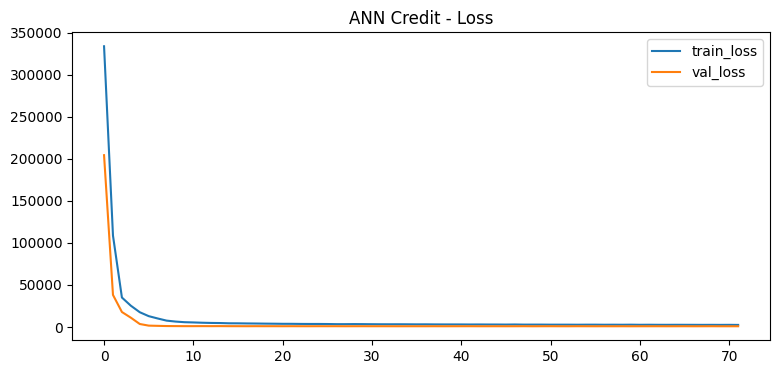

Ann Credit Test MSE: 853.274169921875
Ann Credit Test MAE: 23.052085876464844


In [ ]:
# Plot & evaluate
import matplotlib.pyplot as plt
plt.figure(figsize=(9,4))
plt.plot(history_ann.history['loss'], label='train_loss')
plt.plot(history_ann.history['val_loss'], label='val_loss')
plt.legend(); plt.title("ANN Credit - Loss")
plt.show()

test_loss, test_mae = ann_credit.evaluate(X_test_scaled, y_test, verbose=0)
print("Ann Credit Test MSE:", test_loss)
print("Ann Credit Test MAE:", test_mae)


In [ ]:
# Save model as .h5
ann_credit.save("credit_ann_model.h5")
print("Model saved as credit_ann_model.h5")


Model saved as credit_ann_model.h5


In [ ]:
# Impute numeric NaNs with median, then rebuild + rescale
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib
import pandas as pd # Ensure pandas is imported

# List of fraud features (ensure same order)
fraud_features = [
    'annual_income','joint_income','business_income','property_value',
    'loan_amount','beneficiary_count','repayment_score','id_verified','document_validity'
]
fraud_target = 'fraud_flag'

# --- START FIX ---
# Create a temporary dataframe to perform transformations without altering the original df
df_processed = df.copy()

# Convert categorical features to numerical as per app.py logic
# 'Yes' -> 1, 'No' -> 0 for 'id_verified'. Fillna(0) for any other unexpected value.
df_processed['id_verified'] = df_processed['id_verified'].map({'Yes': 1, 'No': 0}).fillna(0).astype(int)

# 'Valid' -> 1, others ('Expired', 'Pending') -> 0 for 'document_validity'. Fillna(0) for any other unexpected value.
df_processed['document_validity'] = df_processed['document_validity'].map({'Valid': 1, 'Expired': 0, 'Pending': 0}).fillna(0).astype(int)

# Impute numeric columns in df_processed (median)
# Iterate through fraud_features on df_processed
for col in fraud_features:
    # Check if the column is numeric and has NaNs
    if pd.api.types.is_numeric_dtype(df_processed[col]) and df_processed[col].isnull().any():
        med = df_processed[col].median()
        df_processed[col] = df_processed[col].fillna(med)
# --- END FIX ---

# Rebuild df_fraud using the processed df_processed
df_fraud = df_processed[fraud_features + [fraud_target]].copy()

print("Any NaNs in df_fraud by column after median impute:")
print(df_fraud.isnull().sum())

# Recreate arrays and stratified split
Xf = df_fraud[fraud_features].values
yf = df_fraud[fraud_target].values
Xf_train, Xf_test, yf_train, yf_test = train_test_split(
    Xf, yf, test_size=0.2, random_state=42, stratify=yf
)

# Rescale safely (no NaNs now)
scaler_f = StandardScaler()
Xf_train_scaled = scaler_f.fit_transform(Xf_train)
Xf_test_scaled  = scaler_f.transform(Xf_test)
joblib.dump(scaler_f, "fraud_scaler.save")

print("Shapes after impute+split:", Xf_train.shape, Xf_test.shape)
print("Any NaNs in Xf_train_scaled:", np.isnan(Xf_train_scaled).sum())
print("Any Infs in Xf_train_scaled:", np.isinf(Xf_train_scaled).sum())
print("Fraud scaler saved. Ready to train.")

Any NaNs in df_fraud by column after median impute:
annual_income        0
joint_income         0
business_income      0
property_value       0
loan_amount          0
beneficiary_count    0
repayment_score      0
id_verified          0
document_validity    0
fraud_flag           0
dtype: int64
Shapes after impute+split: (16000, 9) (4000, 9)
Any NaNs in Xf_train_scaled: 0
Any Infs in Xf_train_scaled: 0
Fraud scaler saved. Ready to train.


In [ ]:
# Build ANN fraud detection model

from tensorflow.keras import layers, models

ann_fraud = models.Sequential([
    layers.Input(shape=(Xf_train_scaled.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Dense(32, activation='relu'),

    layers.Dense(1, activation='sigmoid')
])

ann_fraud.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

ann_fraud.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_11 (Dense)                │ (None, 64)             │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,009 (11.75 KB)

 Trainable params: 2,881 (11.25 KB)

 Non-trainable params: 128 (512.00 B)

In [ ]:
# Train fraud ANN with class weights
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import EarlyStopping

# compute class weights for imbalance
cw = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(yf_train),
    y=yf_train
)
class_weights = {0: float(cw[0]), 1: float(cw[1])}
print("Class weights:", class_weights)

es_fraud = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True
)

history_fraud_ann = ann_fraud.fit(
    Xf_train_scaled, yf_train,
    validation_split=0.1,
    epochs=80,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[es_fraud],
    verbose=1
)


Class weights: {0: 0.5128862674701885, 1: 19.90049751243781}
Epoch 1/80
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5287 - loss: 0.6655 - val_accuracy: 0.7394 - val_loss: 0.4850
Epoch 2/80
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7220 - loss: 0.5052 - val_accuracy: 0.8094 - val_loss: 0.4212
Epoch 3/80
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7276 - loss: 0.5365 - val_accuracy: 0.8169 - val_loss: 0.3839
Epoch 4/80
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7658 - loss: 0.4902 - val_accuracy: 0.8131 - val_loss: 0.3925
Epoch 5/80
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7874 - loss: 0.4514 - val_accuracy: 0.7538 - val_loss: 0.4617
Epoch 6/80
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7655 - loss: 0.4267 - val_accuracy: 0.8206 - val_loss: 0.3876
Epoch 7/80
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7787 - loss: 0.4538 - val_accuracy: 0.7719 - val_loss: 0.4565
Epoch 8/80
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 

In [ ]:
# Evaluate fraud ANN (detailed metrics)
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_fscore_support

# Predict probabilities and binary labels
probs = ann_fraud.predict(Xf_test_scaled).ravel()
preds = (probs >= 0.5).astype(int)

# Basic metrics
print("Confusion Matrix:")
print(confusion_matrix(yf_test, preds))

print("\nClassification Report:")
print(classification_report(yf_test, preds, digits=4))

# ROC AUC (may be small because data is imbalanced but informative)
try:
    auc = roc_auc_score(yf_test, probs)
    print(f"\nROC AUC: {auc:.4f}")
except Exception as e:
    print("ROC AUC error:", e)

# Also show precision/recall for the positive class explicitly
p, r, f, _ = precision_recall_fscore_support(yf_test, preds, average=None, labels=[1,0])
print(f"\nPositive class (fraud) — Precision: {p[0]:.4f}, Recall: {r[0]:.4f}, F1: {f[0]:.4f}")


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Confusion Matrix:
[[3265  635]
 [  23   77]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9930    0.8372    0.9085      3900
           1     0.1081    0.7700    0.1897       100

    accuracy                         0.8355      4000
   macro avg     0.5506    0.8036    0.5491      4000
weighted avg     0.9709    0.8355    0.8905      4000


ROC AUC: 0.8962

Positive class (fraud) — Precision: 0.1081, Recall: 0.7700, F1: 0.1897


In [ ]:
# Save Fraud ANN Model
ann_fraud.save("fraud_ann_model.h5")
print("Fraud ANN model saved as fraud_ann_model.h5")


Fraud ANN model saved as fraud_ann_model.h5


In [ ]:
# Example predictions for first 10 test samples

probs_10 = ann_fraud.predict(Xf_test_scaled[:10]).ravel()
preds_10 = (probs_10 >= 0.5).astype(int)

for i in range(10):
    print(f"Sample {i+1}:  Fraud Probability = {probs_10[i]:.4f}   Predicted Class = {preds_10[i]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
Sample 1:  Fraud Probability = 0.4328   Predicted Class = 0
Sample 2:  Fraud Probability = 0.2320   Predicted Class = 0
Sample 3:  Fraud Probability = 0.0570   Predicted Class = 0
Sample 4:  Fraud Probability = 0.4654   Predicted Class = 0
Sample 5:  Fraud Probability = 0.3236   Predicted Class = 0
Sample 6:  Fraud Probability = 0.1419   Predicted Class = 0
Sample 7:  Fraud Probability = 0.4901   Predicted Class = 0
Sample 8:  Fraud Probability = 0.5591   Predicted Class = 1
Sample 9:  Fraud Probability = 0.6131   Predicted Class = 1
Sample 10:  Fraud Probability = 0.1388   Predicted Class = 0


In [ ]:
# FRAUD ANN — Accuracy Calculation

loss, accuracy = ann_fraud.evaluate(Xf_test_scaled, yf_test, verbose=0)

print(f"Fraud ANN Accuracy: {accuracy:.4f}")
print(f"Fraud ANN Loss: {loss:.4f}")


Fraud ANN Accuracy: 0.8355
Fraud ANN Loss: 0.3517


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


<Figure size 600x400 with 0 Axes>

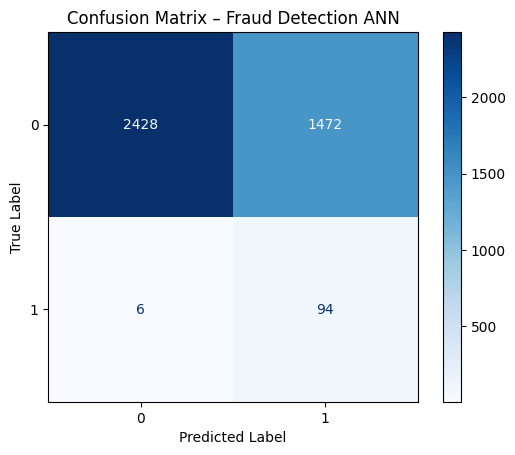

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 1. Generate predicted probabilities for fraud model
y_pred_proba = ann_fraud.predict(Xf_test_scaled)

# 2. Set threshold (use your tuned threshold or 0.23 as suggested)
threshold = 0.23

# 3. Convert probabilities → class predictions
y_pred = (y_pred_proba >= threshold).astype(int)

# 4. Compute confusion matrix
cm = confusion_matrix(yf_test, y_pred)

# 5. Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])

plt.figure(figsize=(6,4))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix – Fraud Detection ANN")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.grid(False)
plt.show()


In [ ]:
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Predictions
y_pred = ann_credit.predict(X_test_scaled).flatten()

# R2 score
r2 = r2_score(y_test, y_pred)

# RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
R² Score: 0.9150
RMSE: 29.2109


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Top 5 thresholds by Recall:
 threshold  precision  recall       f1
      0.01   0.028760    1.00 0.055913
      0.02   0.030941    1.00 0.060024
      0.03   0.032174    0.99 0.062323
      0.04   0.033480    0.99 0.064769
      0.05   0.034970    0.99 0.067554

Top 5 thresholds by F1-score:
 threshold  precision  recall       f1
      0.87   0.420455    0.37 0.393617
      0.88   0.425000    0.34 0.377778
      0.86   0.372549    0.38 0.376238
      0.83   0.319149    0.45 0.373444
      0.85   0.341880    0.40 0.368664

Suggested threshold (heuristic): {'threshold': 0.17, 'precision': 0.05113336847654191, 'recall': 0.97, 'f1': 0.0971457185778668}


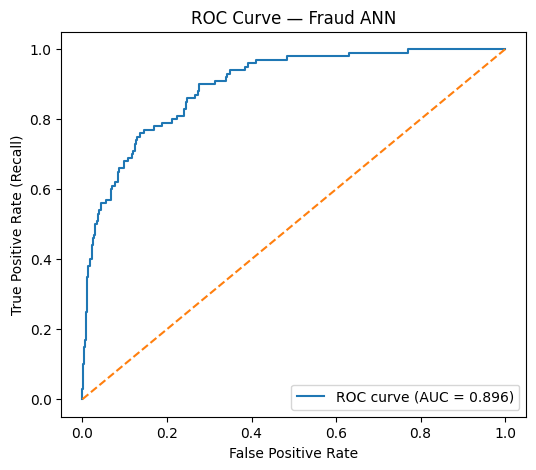


Threshold table (first 10 rows):
 threshold  precision  recall       f1
      0.01   0.028760    1.00 0.055913
      0.02   0.030941    1.00 0.060024
      0.03   0.032174    0.99 0.062323
      0.04   0.033480    0.99 0.064769
      0.05   0.034970    0.99 0.067554
      0.06   0.036518    0.99 0.070438
      0.07   0.038033    0.99 0.073252
      0.08   0.039044    0.98 0.075096
      0.09   0.040446    0.98 0.077685
      0.10   0.041720    0.98 0.080033


In [ ]:
# Threshold tuning and ROC curve

import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
import pandas as pd

# predicted probabilities on test set
probs = ann_fraud.predict(Xf_test_scaled).ravel()

# thresholds to try
thresholds = np.linspace(0.01, 0.99, 99)
rows = []
for t in thresholds:
    preds_t = (probs >= t).astype(int)
    p = precision_score(yf_test, preds_t, zero_division=0)
    r = recall_score(yf_test, preds_t, zero_division=0)
    f = f1_score(yf_test, preds_t, zero_division=0)
    rows.append((t, p, r, f))

df_thresh = pd.DataFrame(rows, columns=['threshold','precision','recall','f1'])
# show top thresholds by recall (useful for fraud detection) and by f1
top_recall = df_thresh.sort_values(by='recall', ascending=False).head(5)
top_f1 = df_thresh.sort_values(by='f1', ascending=False).head(5)

print("Top 5 thresholds by Recall:")
print(top_recall.to_string(index=False))
print("\nTop 5 thresholds by F1-score:")
print(top_f1.to_string(index=False))

# suggest threshold: highest recall while precision >= 0.05 (example heuristic)
candidates = df_thresh[df_thresh['precision'] >= 0.05]
if not candidates.empty:
    suggested = candidates.sort_values(by='recall', ascending=False).iloc[0]
else:
    suggested = df_thresh.sort_values(by='recall', ascending=False).iloc[0]
print("\nSuggested threshold (heuristic):", suggested.to_dict())

# ROC curve
fpr, tpr, roc_thresh = roc_curve(yf_test, probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0,1],[0,1],'--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve — Fraud ANN')
plt.legend()
plt.show()

# Display full table head for inspection
print("\nThreshold table (first 10 rows):")
print(df_thresh.head(10).to_string(index=False))


In [ ]:
ann_credit.save("ann_credit_score.h5")


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Use original (unscaled) train/test splits for tree-based models
# X_train, X_test, y_train, y_test already exist in your code

rf_credit = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

rf_credit.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_credit.predict(X_test)

# Metrics
mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("\n=== Random Forest Credit Model ===")
print(f"MSE  : {mse_rf:.4f}")
print(f"RMSE : {rmse_rf:.4f}")
print(f"MAE  : {mae_rf:.4f}")
print(f"R²   : {r2_rf:.4f}")



=== Random Forest Credit Model ===
MSE  : 880.3077
RMSE : 29.6700
MAE  : 23.3912
R²   : 0.9123


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Use original fraud train/test splits (unscaled)
# Xf_train, Xf_test, yf_train, yf_test already exist

rf_fraud = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf_fraud.fit(Xf_train, yf_train)

# Predictions
rf_probs = rf_fraud.predict_proba(Xf_test)[:, 1]
rf_preds = rf_fraud.predict(Xf_test)

print("\n=== Random Forest Fraud Model ===")
print("Confusion Matrix:")
print(confusion_matrix(yf_test, rf_preds))

print("\nClassification Report:")
print(classification_report(yf_test, rf_preds, digits=4))

try:
    rf_auc = roc_auc_score(yf_test, rf_probs)
    print(f"\nROC AUC: {rf_auc:.4f}")
except Exception as e:
    print("ROC AUC error:", e)



=== Random Forest Fraud Model ===
Confusion Matrix:
[[3900    0]
 [  97    3]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9757    1.0000    0.9877      3900
           1     1.0000    0.0300    0.0583       100

    accuracy                         0.9758      4000
   macro avg     0.9879    0.5150    0.5230      4000
weighted avg     0.9763    0.9758    0.9645      4000


ROC AUC: 0.8577


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score


In [ ]:
# ==========================
# MODEL 2: Residual ANN - Credit Score
# ==========================

from tensorflow.keras import Model

inputs_res = layers.Input(shape=(X_train_scaled.shape[1],))

# First block
x = layers.Dense(128, activation='relu')(inputs_res)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)

# Residual block
res = x
x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Add()([x, res])   # skip connection

# Deeper layers
x = layers.Dense(64, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)

outputs_res = layers.Dense(1)(x)

res_credit = Model(inputs_res, outputs_res)

res_credit.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

es_res = EarlyStopping(
    monitor='val_loss',
    patience=12,
    restore_best_weights=True
)

history_res_credit = res_credit.fit(
    X_train_scaled, y_train,
    validation_split=0.1,
    epochs=120,
    batch_size=32,
    callbacks=[es_res],
    verbose=1
)

# Evaluate Residual ANN
y_pred_res = res_credit.predict(X_test_scaled).flatten()
mse_res = mean_squared_error(y_test, y_pred_res)
rmse_res = np.sqrt(mse_res)
r2_res = r2_score(y_test, y_pred_res)

print("\n=== Residual ANN (Credit) ===")
print(f"MSE  : {mse_res:.4f}")
print(f"RMSE : {rmse_res:.4f}")
print(f"R²   : {r2_res:.4f}")


Epoch 1/120
450/450 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 385724.5312 - mae: 614.3525 - val_loss: 348196.0000 - val_mae: 587.8667
Epoch 2/120
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 331804.4688 - mae: 573.8958 - val_loss: 256851.6875 - val_mae: 505.9070
Epoch 3/120
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 233677.4844 - mae: 480.9088 - val_loss: 152954.1875 - val_mae: 390.0138
Epoch 4/120
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 128374.5703 - mae: 354.4748 - val_loss: 66783.1250 - val_mae: 256.8059
Epoch 5/120
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 52936.0586 - mae: 223.5895 - val_loss: 19149.1934 - val_mae: 135.2885
Epoch 6/120
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 15715.4502 - mae: 114.0555 - val_loss: 4069.7668 - val_mae: 57.8301
Epoch 7/120
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 5149.0659 - mae: 58.1606 - val_loss: 1180.9087 - val_mae: 28.0457
Epoch 8/120
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 3228.9790 - mae: 44.9

In [ ]:
# ==========================
# MODEL 3: Autoencoder + ANN - Credit Score
# ==========================

encoding_dim = 32   # size of compressed representation
input_dim = X_train_scaled.shape[1]

# Autoencoder
input_ae = layers.Input(shape=(input_dim,))
e = layers.Dense(64, activation='relu')(input_ae)
encoded = layers.Dense(encoding_dim, activation='relu', name="encoded")(e)

d = layers.Dense(64, activation='relu')(encoded)
decoded = layers.Dense(input_dim, activation='linear')(d)

autoencoder = models.Model(input_ae, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

es_ae = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history_ae = autoencoder.fit(
    X_train_scaled, X_train_scaled,
    validation_split=0.1,
    epochs=80,
    batch_size=32,
    callbacks=[es_ae],
    verbose=1
)

# Build encoder model to get compressed features
encoder = models.Model(input_ae, encoded)

X_train_enc = encoder.predict(X_train_scaled)
X_test_enc = encoder.predict(X_test_scaled)

# Regressor on top of encoded features
ae_reg = models.Sequential([
    layers.Input(shape=(encoding_dim,)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

ae_reg.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

es_ae_reg = EarlyStopping(
    monitor='val_loss',
    patience=12,
    restore_best_weights=True
)

history_ae_reg = ae_reg.fit(
    X_train_enc, y_train,
    validation_split=0.1,
    epochs=120,
    batch_size=32,
    callbacks=[es_ae_reg],
    verbose=1
)

# Evaluate Autoencoder + ANN
y_pred_ae = ae_reg.predict(X_test_enc).flatten()
mse_ae = mean_squared_error(y_test, y_pred_ae)
rmse_ae = np.sqrt(mse_ae)
r2_ae = r2_score(y_test, y_pred_ae)

print("\n=== Autoencoder + ANN (Credit) ===")
print(f"MSE  : {mse_ae:.4f}")
print(f"RMSE : {rmse_ae:.4f}")
print(f"R²   : {r2_ae:.4f}")


Epoch 1/80
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.3217 - val_loss: 0.0068
Epoch 2/80
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0055 - val_loss: 0.0034
Epoch 3/80
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0031 - val_loss: 0.0023
Epoch 4/80
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0022 - val_loss: 0.0018
Epoch 5/80
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 6/80
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 7/80
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0010 - val_loss: 6.4556e-04
Epoch 8/80
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.2267e-04 - val_loss: 7.4955e-04
Epoch 9/80
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.1448e-04 - val_loss: 4.6291e-04
Epoch 10/80
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.8329e-04 - val_loss: 5.4480e-04
Epoch 11/80
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.6909e-04 - val_loss: 3.0447e-04
Epoch 12/80
450/

In [ ]:
# ==========================
# MODEL 7: 1D CNN + ANN Hybrid - Credit Score
# ==========================

from tensorflow.keras import layers, models

# Reshape input for Conv1D: (samples, features, 1)
X_train_cnn = np.expand_dims(X_train_scaled, axis=-1)
X_test_cnn = np.expand_dims(X_test_scaled, axis=-1)

cnn_model = models.Sequential([
    layers.Input(shape=(X_train_cnn.shape[1], 1)),

    layers.Conv1D(64, kernel_size=3, activation='relu'),
    layers.BatchNormalization(),
    layers.Conv1D(64, kernel_size=3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=2),

    layers.Flatten(),

    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),

    layers.Dense(1)   # Regression Output
])

cnn_model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

es_cnn = EarlyStopping(
    monitor='val_loss',
    patience=12,
    restore_best_weights=True
)

history_cnn = cnn_model.fit(
    X_train_cnn, y_train,
    validation_split=0.1,
    epochs=120,
    batch_size=32,
    callbacks=[es_cnn],
    verbose=1
)

# Predictions and metrics
y_pred_cnn = cnn_model.predict(X_test_cnn).flatten()
mse_cnn = mean_squared_error(y_test, y_pred_cnn)
rmse_cnn = np.sqrt(mse_cnn)
r2_cnn = r2_score(y_test, y_pred_cnn)

print("\n=== 1D CNN + ANN (Credit) ===")
print(f"RMSE : {rmse_cnn:.4f}")
print(f"R²   : {r2_cnn:.4f}")


Epoch 1/120
450/450 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - loss: 168153.7188 - mae: 317.1646 - val_loss: 57884.1055 - val_mae: 236.4423
Epoch 2/120
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 5271.6099 - mae: 57.5633 - val_loss: 2471.9507 - val_mae: 40.2227
Epoch 3/120
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 4978.0947 - mae: 55.8918 - val_loss: 2644.7979 - val_mae: 41.0131
Epoch 4/120
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 4903.3545 - mae: 55.6311 - val_loss: 2528.4871 - val_mae: 41.3118
Epoch 5/120
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 4643.8755 - mae: 54.4270 - val_loss: 1114.9083 - val_mae: 26.2613
Epoch 6/120
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 4688.1494 - mae: 54.1255 - val_loss: 1601.8405 - val_mae: 31.3573
Epoch 7/120
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 4532.0864 - mae: 53.1333 - val_loss: 1099.9790 - val_mae: 26.1571
Epoch 8/120
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4518.2363 - mae: 53.2990 - val_loss: 1258.3

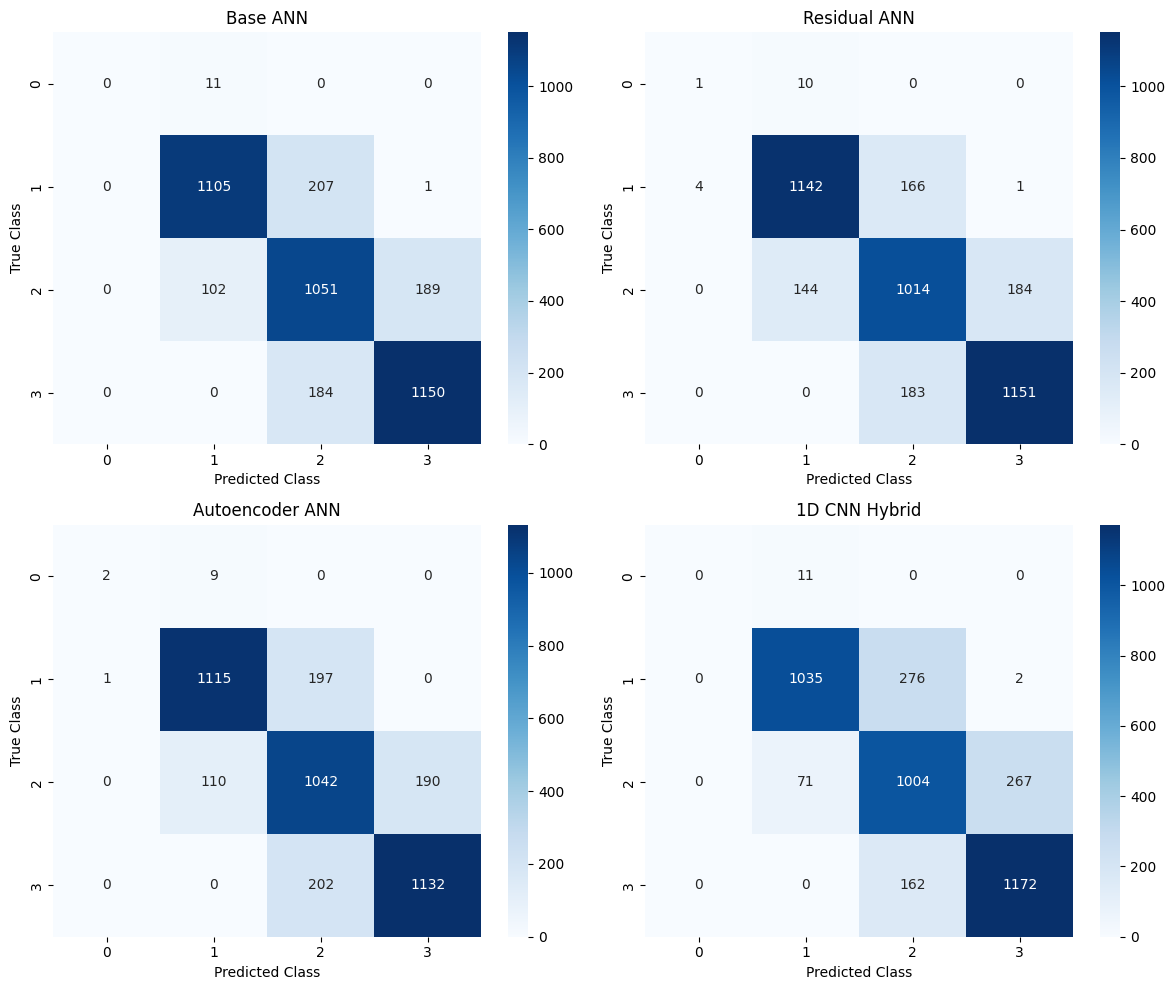

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

models = {
    "Base ANN": y_pred,
    "Residual ANN": y_pred_res,
    "Autoencoder ANN": y_pred_ae,
    "1D CNN Hybrid": y_pred_cnn
}

# Convert regression outputs into categories
bins = np.quantile(y_test, [0, 0.33, 0.66, 1.0])
y_true_class = np.digitize(y_test, bins, right=True) - 1

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

for i, (name, pred) in enumerate(models.items()):
    y_pred_class = np.digitize(pred, bins, right=True) - 1
    cm = confusion_matrix(y_true_class, y_pred_class)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[i])
    axes[i].set_title(name)
    axes[i].set_xlabel("Predicted Class")
    axes[i].set_ylabel("True Class")

plt.tight_layout()
plt.savefig("combined_confusion_matrix.png", dpi=300)
plt.show()


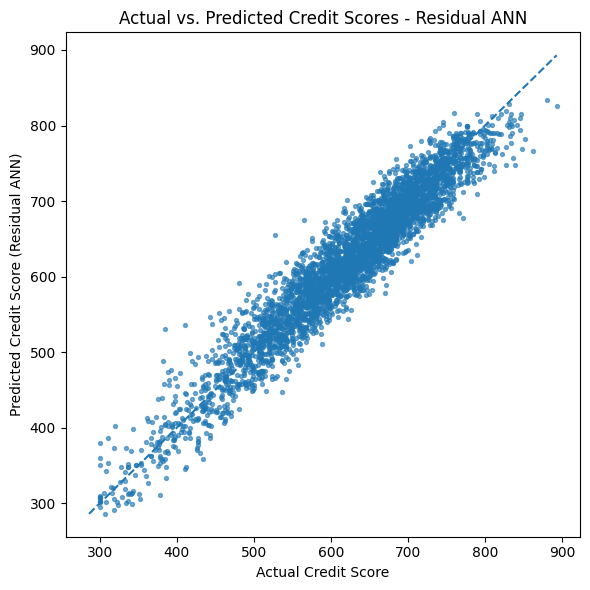

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you already have:
# y_test        -> true credit scores (shape: [n_samples])
# y_pred_res    -> predicted scores from Residual ANN (shape: [n_samples])

# If y_pred_res is 2D (e.g. (n,1)), flatten it:
y_true = np.array(y_test).flatten()
y_pred = np.array(y_pred_res).flatten()

# Create scatter plot
plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred, s=8, alpha=0.6)

# Plot diagonal reference line (perfect prediction)
min_val = min(y_true.min(), y_pred.min())
max_val = max(y_true.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], linestyle="--")

# Labels and title (match LaTeX caption meaning)
plt.xlabel("Actual Credit Score")
plt.ylabel("Predicted Credit Score (Residual ANN)")
plt.title("Actual vs. Predicted Credit Scores - Residual ANN")

plt.tight_layout()
plt.savefig("residual_ann_actual_vs_pred.png", dpi=300)
plt.show()


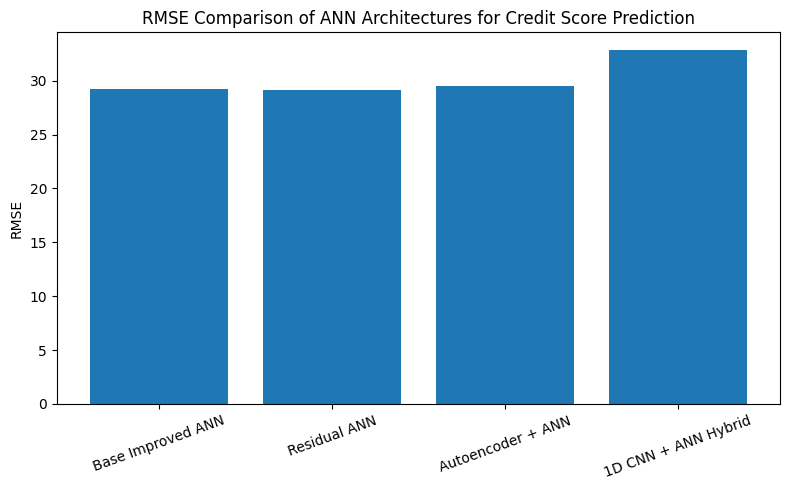

In [ ]:
import matplotlib.pyplot as plt

# RMSE values for the 4 models
models = ["Base Improved ANN", "Residual ANN", "Autoencoder + ANN", "1D CNN + ANN Hybrid"]
rmse_values = [29.2109, 29.1533, 29.4827, 32.8422]

plt.figure(figsize=(8, 5))
plt.bar(models, rmse_values)
plt.ylabel("RMSE")
plt.title("RMSE Comparison of ANN Architectures for Credit Score Prediction")
plt.xticks(rotation=20)
plt.tight_layout()

# Save the figure for LaTeX
plt.savefig("model_rmse_comparison.png", dpi=300)
plt.show()


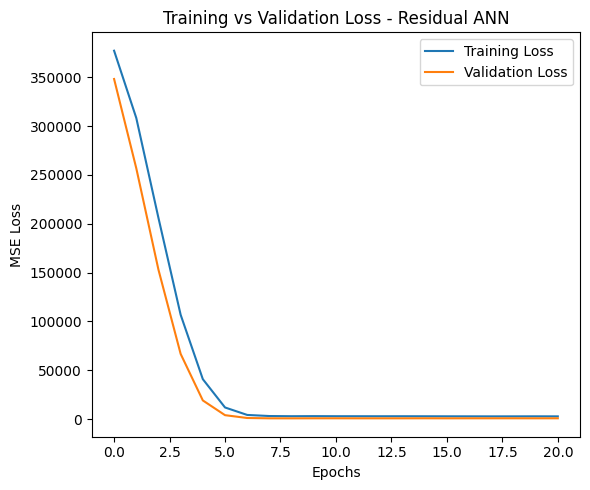

In [ ]:
import matplotlib.pyplot as plt

# history_res = model.fit(...) returned history object from Residual ANN
loss = history_res_credit.history['loss']
val_loss = history_res_credit.history['val_loss']

plt.figure(figsize=(6, 5))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('Training vs Validation Loss - Residual ANN')
plt.legend()
plt.tight_layout()
plt.savefig("residual_ann_training_curve.png", dpi=300)
plt.show()


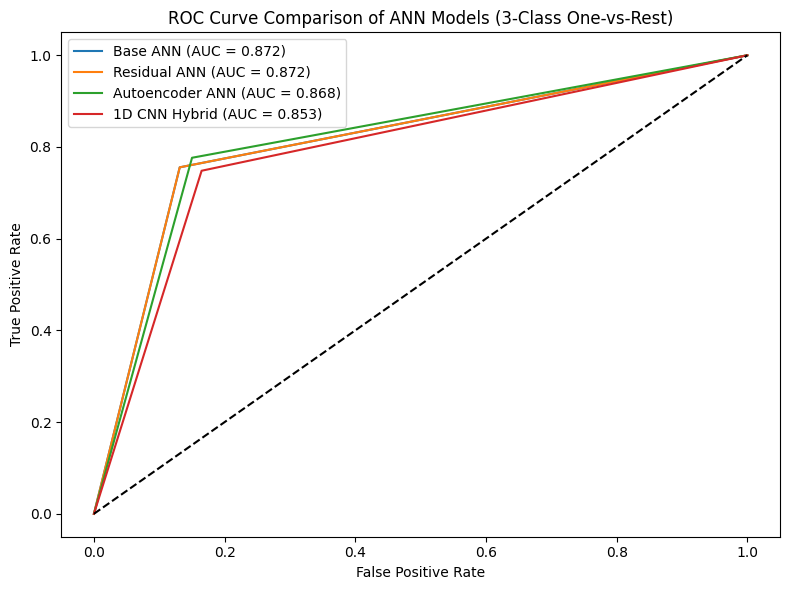

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# True target
y_true = np.array(y_test).flatten()

# Predicted scores from each model
models = {
    "Base ANN": y_pred,
    "Residual ANN": y_pred_res,
    "Autoencoder ANN": y_pred_ae,
    "1D CNN Hybrid": y_pred_cnn
}

# Convert to 3-level classes: Low / Medium / High
bins = np.quantile(y_true, [0, 0.33, 0.66, 1.0])
y_true_class = np.digitize(y_true, bins, right=True) - 1

# Binarize true labels for ROC (multiclass)
y_true_bin = label_binarize(y_true_class, classes=[0, 1, 2])

plt.figure(figsize=(8, 6))

for name, pred in models.items():
    pred_class = np.digitize(pred, bins, right=True) - 1
    pred_bin = label_binarize(pred_class, classes=[0, 1, 2])

    # Compute ROC curves for each class & average macro AUC
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(3):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], pred_bin[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    mean_auc = np.mean(list(roc_auc.values()))
    plt.plot(fpr[1], tpr[1], label=f"{name} (AUC = {mean_auc:.3f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison of ANN Models (3-Class One-vs-Rest)")
plt.legend()
plt.tight_layout()
plt.savefig("roc_curve_comparison.png", dpi=300)
plt.show()
